In [1]:
# This notebook is used to decide on a tolerable level of corruptableness.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.stats import entropy as KL_divergence

from lda_cython.topic_models import LDA
from modules.helpers import plot_images

In [2]:
# Generate topics
# We assume a vocabulary of 'rows'^2 terms, and create 'rows'*2 "topics",
# where each topic assigns exactly 'rows' consecutive terms equal probability.
rows = 3
V = rows * rows
K = rows * 2
N = K * K
D = 10000
seed = 42
topics = []
topic_base = np.concatenate((np.ones((1, rows)) * (1/rows),
                             np.zeros((rows-1, rows))), axis=0).ravel()
for i in range(rows):
     topics.append(np.roll(topic_base, i * rows))
topic_base = np.concatenate((np.ones((rows, 1)) * (1/rows),
                             np.zeros((rows, rows-1))), axis=1).ravel()
for i in range(rows):
    topics.append(np.roll(topic_base, i))
topics = np.array(topics)

# Generate documents from topics
# We generate D documents from these V topics by sampling D topic
# distributions, one for each document, from a Dirichlet distribution with
# parameter α=(1,…,1)
alpha = np.ones(K)
np.random.seed(seed)
thetas = np.random.dirichlet(alpha, size=D)
topic_assignments = np.array([np.random.choice(range(K), size=N, p=theta)
                              for theta in thetas])
word_assignments = np.array([[np.random.choice(range(V), size=1,
                                               p=topics[topic_assignments[d, n]])[0]
                              for n in range(N)] for d in range(D)])
doc_term_matrix = np.array([np.histogram(word_assignments[d], bins=V,
                                         range=(0, V - 1))[0] for d in range(D)])

# Generate responses
# Choose prameter values
np.random.seed(seed)

# Estimate parameters
_K = K
_alpha = alpha
_beta = np.repeat(0.01, V)
n_iter = 2000
lda = LDA(_K, _alpha, _beta, n_iter, seed=42)

lda.fit(doc_term_matrix)
results = lda.phi

2016-06-16 13:49:36.816993 start iterations
2016-06-16 13:49:37.067183 0:00:00.250190 elapsed, iter   10, LL -1437405.5555, 4.24% change from last
2016-06-16 13:49:37.288888 0:00:00.471895 elapsed, iter   20, LL -1292458.5259, 10.08% change from last
2016-06-16 13:49:37.507131 0:00:00.690138 elapsed, iter   30, LL -1222462.6581, 5.42% change from last
2016-06-16 13:49:37.712439 0:00:00.895446 elapsed, iter   40, LL -1193247.2897, 2.39% change from last
2016-06-16 13:49:37.925364 0:00:01.108371 elapsed, iter   50, LL -1177533.2230, 1.32% change from last
2016-06-16 13:49:38.125334 0:00:01.308341 elapsed, iter   60, LL -1171413.2940, 0.52% change from last
2016-06-16 13:49:38.332386 0:00:01.515393 elapsed, iter   70, LL -1170943.1427, 0.04% change from last
2016-06-16 13:49:38.538035 0:00:01.721042 elapsed, iter   80, LL -1164091.9810, 0.59% change from last
2016-06-16 13:49:38.744072 0:00:01.927079 elapsed, iter   90, LL -1152807.8121, 0.97% change from last
2016-06-16 13:49:38.952793 0

In [3]:
for res in results:
    minimized_KL = 1
    for topic in topics:
        KL = KL_divergence(topic, res)
        if KL < minimized_KL:
            minimized_KL = KL
    print(minimized_KL)

5.34768078599e-05
0.000173033500443
0.000304934534738
0.000311130904051
0.000231199587745
1.03023470842e-05


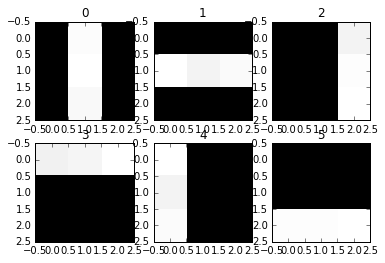

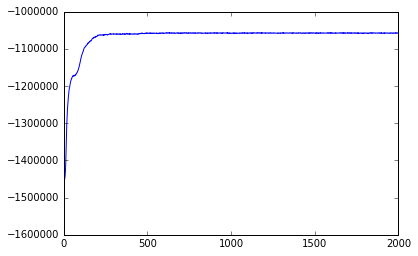

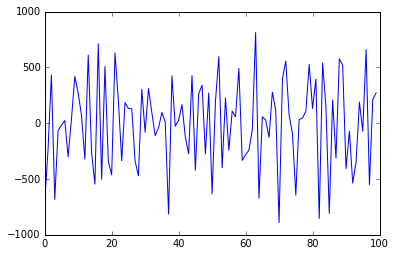

In [4]:
plot_images(plt, results, (rows, rows), (2, rows))
plt.figure()
plt.plot(lda.loglikelihoods)
plt.figure()
plt.plot(np.diff(lda.loglikelihoods)[-100:])